In [ ]:
# Subí tu Token a Google Colab
from google.colab import files

# Sube el archivo kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucianoandreslabudia","key":"8765b6a8ac02feb629bb98ed823b33cb"}'}

In [ ]:
# Crea el directorio de Kaggle
!mkdir -p ~/.kaggle

# Copia el token de la API al directorio
!cp kaggle.json ~/.kaggle/

# Asigna los permisos correctos al archivo
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Comando específico para el dataset de Tweets de COVID-19
!kaggle datasets download -d gpreda/covid19-tweets

Dataset URL: https://www.kaggle.com/datasets/gpreda/covid19-tweets
License(s): CC0-1.0
  0% 0.00/27.9M [00:00<?, ?B/s]
100% 27.9M/27.9M [00:00<00:00, 1.14GB/s]


In [ ]:
# Descomprime el archivo descargado
!unzip covid19-tweets.zip

Archive:  covid19-tweets.zip
  inflating: covid19_tweets.csv      


## Instalar & importar librerías

In [ ]:
!pip install --quiet langdetect nltk

import nltk, unicodedata, string, re, textwrap, matplotlib.pyplot as plt
from nltk.corpus import stopwords # lista de palabras vacías
from collections import Counter  # cuenta frecuencia
from statistics import mean, median
import langdetect, matplotlib
import pandas as pd # Añadido para cargar el CSV

# Hacemos que los gráficos se vean más nítidos en Colab
matplotlib.rcParams["figure.dpi"] = 120   # gráficos nítidos

# --- Descarga de recursos NLTK para INGLÉS ---
print("Descargando recursos de NLTK para inglés...")
nltk.download("stopwords", quiet=True)  # Stopwords (incluye inglés)
nltk.download("punkt", quiet=True)      # Necesario para tokenizar (dividir en palabras)
nltk.download("wordnet", quiet=True)    # Necesario para lematización en inglés
nltk.download("omw-1.4", quiet=True)    # Necesario para WordNetLemmatizer en versiones recientes
nltk.download("punkt_tab", quiet=True) # Descargar el recurso punkt_tab faltante
print("Recursos de NLTK descargados.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Descargando recursos de NLTK para inglés...
Recursos de NLTK descargados.


## Cargar el Dataset en un DataFrame de Pandas

Se carga el archivo CSV en un DataFrame de pandas. Esto permitirá manipular los datos fácilmente.

In [ ]:
# Cargar el dataset desde la ruta de Drive
try:
    df = pd.read_csv('covid19_tweets.csv')
    print("Dataset cargado exitosamente.")
    print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta: {covid19_tweets}")
    print("Por favor, verifica que la ruta a tu archivo en Google Drive sea correcta.")

# Muestra las primeras 5 filas para entender la estructura
if 'df' in locals():
    print("\nPrimeras 5 filas del dataset:")
    display(df.head())

Dataset cargado exitosamente.
El dataset tiene 179108 filas y 13 columnas.

Primeras 5 filas del dataset:


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


## Crear la Función de Limpieza clean_text() para Inglés

Se crea una función que tome un texto de un tweet y lo devuelve limpio.

* **Convertir a minúsculas**: Estandariza el texto.
* **Eliminar URLs, menciones (@) y hashtags (#)**: Son elementos muy comunes en tweets que no suelen aportar al análisis de frecuencia de palabras.
* **Eliminar puntuación y números.**
* **Tokenizar**: Dividir el texto en una lista de palabras.
* **Eliminar Stopwords en Inglés**: Aca aplicamos el: stopwords.words("english").
* **Lematizar**: Reducir las palabras a su forma base (por ejemplo, "studies", "studying" -> "study"). Es más avanzado que el stemming y suele dar mejores resultados.

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# --- Preparación para la limpieza ---

# 1. Obtener la lista de stopwords en INGLÉS
stop_words_en = set(stopwords.words('english'))

# 2. Inicializar el Lematizador
lemmatizer = WordNetLemmatizer()

# --- Definición de la función clean_text ---

def clean_text(text):
    """
    Función para preprocesar un texto:
    1. Convierte a minúsculas.
    2. Elimina URLs.
    3. Elimina menciones de usuario (@) y hashtags (#) (solo el símbolo, no el texto).
    4. Elimina signos de puntuación.
    5. Elimina números.
    6. Tokeniza el texto.
    7. Elimina stopwords en inglés.
    8. Lematiza las palabras.
    9. Une las palabras en un string limpio.
    """
    if not isinstance(text, str):
        return ""

    # 1. Convertir a minúsculas
    text = text.lower()

    # 2. Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # 3. Eliminar menciones y hashtags (símbolos)
    text = re.sub(r'[@#]', '', text)

    # 4. Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 5. Eliminar números
    text = re.sub(r'\d+', '', text)

    # 6. Tokenizar (dividir en palabras)
    words = word_tokenize(text)

    # 7. y 8. Eliminar stopwords y lematizar
    cleaned_words = [
        lemmatizer.lemmatize(word) for word in words if word not in stop_words_en and len(word) > 2
    ]

    # 9. Unir las palabras de nuevo en un solo string
    return " ".join(cleaned_words)

print("\nFunción 'clean_text' creada exitosamente.")


Función 'clean_text' creada exitosamente.


## Aplicar la Función a tu DataFrame

Ahora que se tiene la función, aplicamos a la columna que contiene los tweets. Se crea una nueva columna, cleaned_text, para guardar el resultado.

In [ ]:
# 1. Aplicar la función 'clean_text' a la columna 'text'.
#    El método .apply() ejecuta la función para cada elemento de la columna.
print("Aplicando la función de limpieza a todos los tweets. Esto puede tardar unos segundos...")
df['cleaned_text'] = df['text'].apply(clean_text)
print("¡Limpieza completada!")

# 2. VERIFICAR EL RESULTADO
#    Mostramos las primeras 10 filas con la columna original y la nueva columna limpia
#    para que puedas comparar el antes y el después.
print("\n--- Verificación: Texto Original vs. Texto Limpio ---")
display(df[['text', 'cleaned_text']].head(10))

Aplicando la función de limpieza a todos los tweets. Esto puede tardar unos segundos...
¡Limpieza completada!

--- Verificación: Texto Original vs. Texto Limpio ---


,text,cleaned_text
0,If I smelled the scent of hand sanitizers toda...,smelled scent hand sanitizers today someone pa...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,hey yankee yankeespr mlb wouldnt made sense pl...
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,diane wdunlap realdonaldtrump trump never clai...
3,@brookbanktv The one gift #COVID19 has give me...,brookbanktv one gift covid give appreciation s...
4,25 July : Media Bulletin on Novel #CoronaVirus...,july medium bulletin novel coronavirusupdates ...
5,#coronavirus #covid19 deaths continue to rise....,coronavirus covid death continue rise almost b...
6,How #COVID19 Will Change Work in General (and ...,covid change work general recruiting specifica...
7,You now have to wear face coverings when out s...,wear face covering shopping includes visit loc...
8,Praying for good health and recovery of @Chouh...,praying good health recovery chouhanshivraj co...
9,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...,pope god prophet sadhu sundar selvaraj watch h...


## **Análisis de Frecuencia**: Cuenta las palabras más comunes en la columna cleaned_text.

In [ ]:
# Unir todo el texto limpio en un solo gran string
full_text = " ".join(df['cleaned_text'].dropna())

# Tokenizar ese gran string
all_words = word_tokenize(full_text)

# Calcular la frecuencia de cada palabra
word_counts = Counter(all_words)

# Mostrar las 20 palabras más comunes
print("\nLas 20 palabras más comunes en los tweets son:")
display(word_counts.most_common(20))


Las 20 palabras más comunes en los tweets son:


[('covid', 110835),
 ('case', 20395),
 ('new', 14767),
 ('coronavirus', 14212),
 ('amp', 11932),
 ('death', 9984),
 ('people', 9445),
 ('pandemic', 8114),
 ('mask', 6628),
 ('day', 6136),
 ('one', 5323),
 ('need', 5228),
 ('health', 5225),
 ('today', 5189),
 ('get', 4963),
 ('positive', 4899),
 ('india', 4770),
 ('time', 4765),
 ('total', 4746),
 ('test', 4455)]

## Nube de Palabras (Word Cloud): Visualización, mostrando las palabras por tamaño en base a su uso.

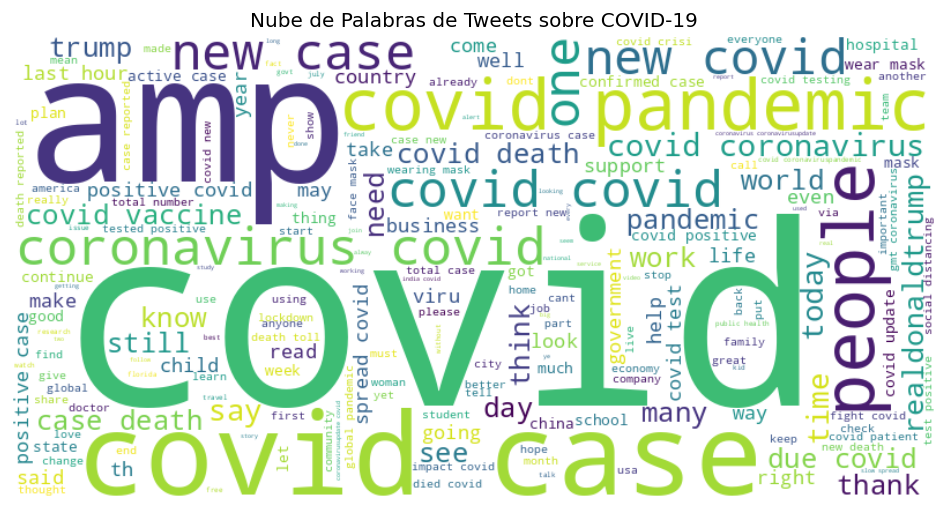

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(full_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras de Tweets sobre COVID-19")
plt.show()

## Requisitos de Preprocesamiento (¡Ya cumplidos! ✅)

* **Lematización**: Hecho✅. Se uso WordNetLemmatizer para llevar las palabras a su raíz.
* **Tokenización**: Hecho✅. Se uso word_tokenize para dividir el texto en palabras.
* **Remoción de stopwords**: Hecho✅. Se uso stopwords.words('english') para eliminar palabras vacías.

## Limpieza y Normalización del Texto con spaCy

In [ ]:
# Instalamos spaCy
!pip install -U spacy

# Descargamos el modelo pequeño de inglés
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 113.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [18]:
# -----------------------------------------------------------------
# CÓDIGO COMPLETO PARA LIMPIEZA CON SPACY
# -----------------------------------------------------------------
import spacy
import pandas as pd # Asegúrate de que pandas esté importado
# Asumo que tu DataFrame 'df' ya está cargado de los pasos anteriores

# --- PASO 1: Cargar el Modelo ---
try:
    # Deshabilitamos componentes no necesarios para acelerar el proceso
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    print("Modelo 'en_core_web_sm' de spaCy cargado exitosamente.")
except OSError:
    print("Modelo 'en_core_web_sm' no encontrado.")
    print("Asegúrate de haberlo descargado con: python -m spacy download en_core_web_sm")


# --- PASO 2: Crear la Función de Limpieza ---
def clean_text_spacy(text):
    """
    Función para preprocesar texto usando spaCy:
    - Lematiza, convierte a minúsculas, elimina stopwords, puntuación y no alfabéticos.
    """
    if not isinstance(text, str):
        return ""

    doc = nlp(text)
    cleaned_tokens = [
        token.lemma_.lower().strip()
        for token in doc
        if not token.is_stop and
           not token.is_punct and
           token.is_alpha and
           len(token.lemma_) > 2
    ]
    return " ".join(cleaned_tokens)

print("\nFunción 'clean_text_spacy' creada exitosamente.")


# --- PASO 3: Aplicar y Comparar ---
print("\nAplicando la función de limpieza de spaCy...")
df['cleaned_text_spacy'] = df['text'].apply(clean_text_spacy)
print("¡Limpieza con spaCy completada!")

print("\n--- Comparación: Texto Original vs. Limpieza con NLTK vs. Limpieza con spaCy ---")
# Usamos display si estás en un notebook, sino usa print
display(df[['text', 'cleaned_text', 'cleaned_text_spacy']].head(10))

Modelo 'en_core_web_sm' de spaCy cargado exitosamente.

Función 'clean_text_spacy' creada exitosamente.

Aplicando la función de limpieza de spaCy...
¡Limpieza con spaCy completada!

--- Comparación: Texto Original vs. Limpieza con NLTK vs. Limpieza con spaCy ---


,text,cleaned_text,cleaned_text_spacy
0,If I smelled the scent of hand sanitizers toda...,smelled scent hand sanitizers today someone pa...,smell scent hand sanitizer today past think in...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,hey yankee yankeespr mlb wouldnt made sense pl...,hey sense player pay respect
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,diane wdunlap realdonaldtrump trump never clai...,trump claim hoax claim effort
3,@brookbanktv The one gift #COVID19 has give me...,brookbanktv one gift covid give appreciation s...,gift appreciation simple thing
4,25 July : Media Bulletin on Novel #CoronaVirus...,july medium bulletin novel coronavirusupdates ...,july media bulletin novel coronavirusupdate
5,#coronavirus #covid19 deaths continue to rise....,coronavirus covid death continue rise almost b...,coronavirus death continue rise bad politician...
6,How #COVID19 Will Change Work in General (and ...,covid change work general recruiting specifica...,change work general recruit specifically recru...
7,You now have to wear face coverings when out s...,wear face covering shopping includes visit loc...,wear face covering shop include visit local co...
8,Praying for good health and recovery of @Chouh...,praying good health recovery chouhanshivraj co...,pray good health recovery covidpositive
9,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...,pope god prophet sadhu sundar selvaraj watch h...,pope god prophet sadhu sundar selvaraj watch h...


## Construcción y Entrenamiento del Modelo

1. **Dividiremos** nuestros datos en un conjunto de entrenamiento y uno de prueba.
2. **Vectorizaremos** el texto, es decir, lo convertiremos en números usando la técnica TF-IDF.
3. **Entrenaremos** un modelo de Regresión Logística.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import pandas as pd

# Asumo que tu DataFrame 'df' ya está cargado y contiene la columna 'cleaned_text_spacy'

# --------------------------------------------------------------------------
# PASO 0: CREAR LA VARIABLE OBJETIVO (y)
# --------------------------------------------------------------------------
# Creamos nuestra variable objetivo. Será 1 si "death" está en el texto limpio, 0 si no.
target_word = 'death'
df['contains_target_word'] = df['cleaned_text_spacy'].apply(lambda text: 1 if target_word in text.split() else 0)

# Definimos nuestras características (X) y nuestro objetivo (y)
X = df['cleaned_text_spacy']
y = df['contains_target_word']

# Verificamos la distribución de nuestras clases
print("Distribución de la variable objetivo:")
print(y.value_counts())
print("-" * 30)

# --------------------------------------------------------------------------
# PASO 1: DIVIDIR LOS DATOS EN ENTRENAMIENTO Y PRUEBA
# --------------------------------------------------------------------------
# Dividimos los datos para poder entrenar el modelo y evaluarlo en datos que nunca ha visto.
# test_size=0.2 significa que el 20% de los datos se usarán para la prueba.
# random_state=42 asegura que la división sea siempre la misma, para reproducibilidad.
# stratify=y asegura que la proporción de 0s y 1s sea la misma en el conjunto de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)} filas")
print(f"Tamaño del conjunto de prueba: {len(X_test)} filas")
print("-" * 30)

# --------------------------------------------------------------------------
# PASO 2 Y 3: VECTORIZAR Y ENTRENAR (usando un Pipeline)
# --------------------------------------------------------------------------
# Usamos un Pipeline para encadenar la vectorización y el entrenamiento.
# Esto es una buena práctica ya que previene la fuga de datos (data leakage) y simplifica el código.

# 1. TfidfVectorizer: Convierte el texto en una matriz de características numéricas TF-IDF.
#    - max_features=5000: Solo consideraremos las 5000 palabras más frecuentes.
#    - ngram_range=(1, 2): Consideraremos palabras individuales (unigramas) y pares de palabras (bigramas).
# 2. LogisticRegression: Nuestro modelo de clasificación.
#    - C=1.0: Parámetro de regularización.
#    - solver='liblinear': Un buen solucionador para este tipo de problema.

pipeline = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    LogisticRegression(C=1.0, solver='liblinear', random_state=42)
)

# ¡Entrenamos el pipeline completo con nuestros datos de entrenamiento!
print("Entrenando el modelo...")
pipeline.fit(X_train, y_train)
print("¡Modelo entrenado exitosamente!")
print("-" * 30)

# El objeto 'pipeline' ahora es nuestro modelo entrenado, listo para hacer predicciones.
print("El pipeline del modelo contiene:")
print(pipeline)

Distribución de la variable objetivo:
contains_target_word
0    169825
1      9283
Name: count, dtype: int64
------------------------------
Tamaño del conjunto de entrenamiento: 143286 filas
Tamaño del conjunto de prueba: 35822 filas
------------------------------
Entrenando el modelo...
¡Modelo entrenado exitosamente!
------------------------------
El pipeline del modelo contiene:
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('logisticregression',
                 LogisticRegression(random_state=42, solver='liblinear'))])


## Evaluación del Modelo

Realizando predicciones en el conjunto de prueba...
¡Predicciones completadas!
------------------------------
Exactitud del modelo: 0.9999
------------------------------
Reporte de Clasificación:
                      precision    recall  f1-score   support

No "death" (Clase 0)       1.00      1.00      1.00     33965
   "death" (Clase 1)       1.00      1.00      1.00      1857

            accuracy                           1.00     35822
           macro avg       1.00      1.00      1.00     35822
        weighted avg       1.00      1.00      1.00     35822

------------------------------
Matriz de Confusión:


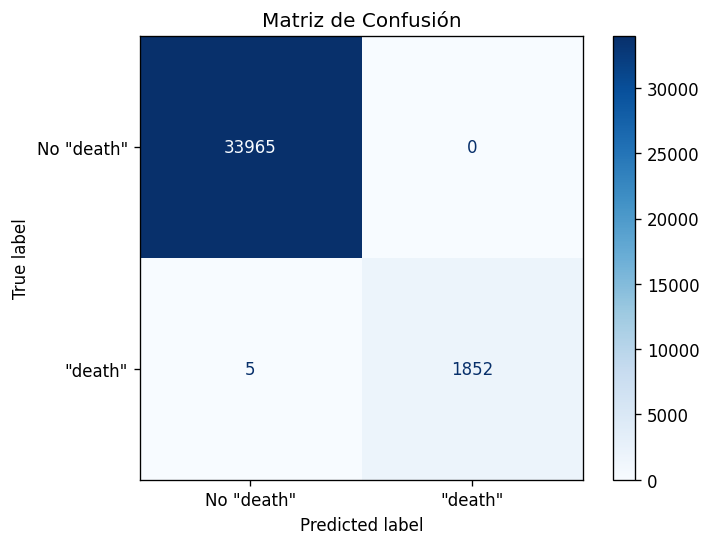

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------
# PASO 1: REALIZAR PREDICCIONES EN EL CONJUNTO DE PRUEBA
# --------------------------------------------------------------------------
# Usamos el pipeline entrenado para predecir las etiquetas del conjunto de prueba (X_test)
print("Realizando predicciones en el conjunto de prueba...")
y_pred = pipeline.predict(X_test)
print("¡Predicciones completadas!")
print("-" * 30)

# --------------------------------------------------------------------------
# PASO 2: GENERAR Y MOSTRAR LAS MÉTRICAS DE EVALUACIÓN
# --------------------------------------------------------------------------

# 1. Exactitud (Accuracy)
# Mide el porcentaje total de predicciones correctas.
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo: {accuracy:.4f}")
print("-" * 30)


# 2. Reporte de Clasificación (La métrica más importante aquí)
# Nos da una visión detallada del rendimiento para cada clase.
print("Reporte de Clasificación:")
# Comparamos las etiquetas reales (y_test) con las predicciones del modelo (y_pred).
# `target_names` nos ayuda a identificar a qué clase corresponde cada fila.
class_report = classification_report(y_test, y_pred, target_names=['No "death" (Clase 0)', '"death" (Clase 1)'])
print(class_report)
print("-" * 30)


# 3. Matriz de Confusión
# Nos permite ver el número exacto de aciertos y errores.
print("Matriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)

# Usamos un gráfico para que la matriz sea más fácil de interpretar.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No "death"', '"death"'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

El modelo logró esta performance porque la tarea era muy directa. La presencia de la palabra "death" en el texto es un indicador potentísimo para la etiqueta que creamos. El modelo de Regresión Logística aprendió fácilmente a asociar la alta puntuación TF-IDF de la palabra "death" con la clase 1.

## Probar el Modelo

In [21]:
import numpy as np

def predecir_tweet(texto):
    """
    Toma un string de texto, lo limpia y usa el pipeline entrenado
    para predecir si contiene la palabra "death".
    Además, muestra la confianza de la predicción.
    """
    # 1. Limpiar el texto nuevo usando la misma función que antes
    texto_limpio = clean_text_spacy(texto)

    # 2. Usar el pipeline para predecir. Lo envolvemos en una lista [].
    prediccion_numerica = pipeline.predict([texto_limpio])[0]

    # 3. Obtener las probabilidades para entender la "confianza" del modelo
    probabilidades = pipeline.predict_proba([texto_limpio])[0]
    confianza = np.max(probabilidades)

    # 4. Traducir el resultado numérico a una etiqueta legible
    etiqueta_prediccion = '"death"' if prediccion_numerica == 1 else 'No "death"'

    # 5. Imprimir los resultados de forma clara
    print(f'Tweet Original: "{texto}"')
    print(f'Texto Limpio: "{texto_limpio}"')
    print(f'---> Predicción: {etiqueta_prediccion} (Confianza: {confianza:.2%})')
    print("-" * 50)


# --- ¡AQUÍ EMPIEZA LA DIVERSIÓN! ---
# Lista de tweets de ejemplo para probar. ¡Añade los tuyos!

nuevos_tweets = [
    "The number of deaths from the virus is still rising.", # Ejemplo claro con "death"
    "I am very concerned about the health of my family.",    # Ejemplo sin la palabra clave
    "Covid cases are going down, but every death is a tragedy.", # Otro ejemplo claro
    "This situation is terrible, so many people have passed away.", # Usa un sinónimo, el modelo probablemente falle aquí
    "We need to stay home to prevent the spread and any more death or disease.", # Ejemplo con "death" y otras palabras
    "I just got my vaccine, I feel great!" # Ejemplo positivo sin la palabra clave
]

# Probamos el modelo con cada uno de los nuevos tweets
for tweet in nuevos_tweets:
    predecir_tweet(tweet)

Tweet Original: "The number of deaths from the virus is still rising."
Texto Limpio: "number death virus rise"
---> Predicción: "death" (Confianza: 99.99%)
--------------------------------------------------
Tweet Original: "I am very concerned about the health of my family."
Texto Limpio: "concerned health family"
---> Predicción: No "death" (Confianza: 99.85%)
--------------------------------------------------
Tweet Original: "Covid cases are going down, but every death is a tragedy."
Texto Limpio: "covid case death tragedy"
---> Predicción: "death" (Confianza: 99.93%)
--------------------------------------------------
Tweet Original: "This situation is terrible, so many people have passed away."
Texto Limpio: "situation terrible people pass away"
---> Predicción: No "death" (Confianza: 99.84%)
--------------------------------------------------
Tweet Original: "We need to stay home to prevent the spread and any more death or disease."
Texto Limpio: "need stay home prevent spread death